# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [12]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    while not stop_condition:
        #print(target_seq)
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)

        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [13]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Load data

In [14]:
data_path = '../../dat/'

In [15]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [16]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [17]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [18]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

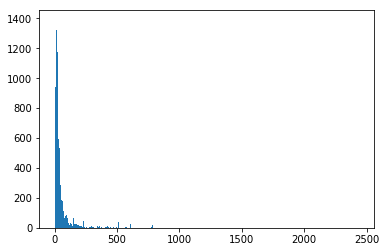

In [19]:
h = plt.hist(lengths, bins=500)

In [20]:
h[0]

array([ 1180.,   940.,  1384.,  1322.,  1174.,   722.,   592.,   536.,
         332.,   286.,   242.,   186.,   180.,   214.,   112.,   154.,
          68.,    82.,    58.,    88.,    70.,    64.,    32.,    30.,
          20.,    26.,    32.,    24.,    58.,    14.,    64.,     6.,
          28.,    16.,    24.,    28.,     8.,    18.,    14.,    18.,
          12.,    24.,    14.,    28.,    14.,     4.,    12.,    44.,
           4.,     6.,     2.,     4.,     6.,     0.,    36.,     0.,
           4.,     4.,     8.,     6.,    14.,     8.,     8.,     8.,
           2.,     0.,     6.,     2.,     2.,     4.,    12.,    14.,
           8.,    12.,     6.,     0.,     4.,     4.,     2.,     0.,
           2.,     0.,     4.,     6.,     0.,     4.,    14.,    26.,
           4.,     0.,     2.,     4.,     4.,     2.,     4.,     2.,
           6.,     0.,     2.,     2.,     2.,     6.,     4.,     2.,
          40.,     4.,     0.,     0.,     2.,     0.,     0.,     0.,
      

In [21]:
h[1]

array([    0.   ,     4.878,     9.756,    14.634,    19.512,    24.39 ,
          29.268,    34.146,    39.024,    43.902,    48.78 ,    53.658,
          58.536,    63.414,    68.292,    73.17 ,    78.048,    82.926,
          87.804,    92.682,    97.56 ,   102.438,   107.316,   112.194,
         117.072,   121.95 ,   126.828,   131.706,   136.584,   141.462,
         146.34 ,   151.218,   156.096,   160.974,   165.852,   170.73 ,
         175.608,   180.486,   185.364,   190.242,   195.12 ,   199.998,
         204.876,   209.754,   214.632,   219.51 ,   224.388,   229.266,
         234.144,   239.022,   243.9  ,   248.778,   253.656,   258.534,
         263.412,   268.29 ,   273.168,   278.046,   282.924,   287.802,
         292.68 ,   297.558,   302.436,   307.314,   312.192,   317.07 ,
         321.948,   326.826,   331.704,   336.582,   341.46 ,   346.338,
         351.216,   356.094,   360.972,   365.85 ,   370.728,   375.606,
         380.484,   385.362,   390.24 ,   395.118, 

In [22]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [23]:
max_sent_len =  100#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [24]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  100
Min length =  4


In [25]:
num_samples = 1000000

tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR_tess, target_texts_tess, gt_tess = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

num_samples = 0
OCR_data = os.path.join(data_path, 'output_handwritten.txt')
input_texts_OCR_hand, target_texts_OCR_hand, gt_texts_OCR_hand = load_data_with_gt(OCR_data, num_samples, max_sent_len, min_sent_len, delimiter='|',gt_index=0, prediction_index=1)

In [26]:
#input_texts = input_texts_OCR
#target_texts = target_texts_OCR
input_texts_OCR = input_texts_OCR_tess + input_texts_OCR_hand
target_texts_OCR = target_texts_tess + target_texts_OCR_hand


In [27]:
len(input_texts_OCR)

4316

# Results of pre-training on generic data

In [28]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [29]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [30]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [31]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [32]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [33]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [34]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [35]:
# TODO

In [36]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

14316
Claim Type: VB Accident - Accidental njury 
 	Claim Type: VB Accident - Accidental Injury


Who The Reported EventH appened To: Employe/ePolicyholder 
 	Who The Reported Event Happened To: Employee/Policyholder


PolicyholdderO/wnerI nformalthiony 
 	Policyholder/Owner Information


Firs Name: 
 	First Name:


Middle Name/Initial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Soial Shecuritvy Numebr: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Language Preference: 
 	Language Preference:




## Build vocab

In [37]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [38]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [39]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 14316
Number of unique input tokens: 117
Number of unique output tokens: 117
Max sequence length for inputs: 99
Max sequence length for outputs: 99


In [40]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 75,
 '"': 82,
 '#': 69,
 '$': 83,
 '%': 79,
 '&': 76,
 "'": 87,
 '(': 65,
 ')': 66,
 '*': 80,
 '+': 78,
 ',': 58,
 '-': 21,
 '.': 50,
 '/': 33,
 '0': 54,
 '1': 48,
 '2': 53,
 '3': 56,
 '4': 68,
 '5': 74,
 '6': 55,
 '7': 71,
 '8': 62,
 '9': 73,
 ':': 13,
 ';': 77,
 '<': 101,
 '=': 96,
 '>': 102,
 '?': 61,
 '@': 85,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 45,
 'E': 30,
 'F': 38,
 'G': 46,
 'H': 32,
 'I': 22,
 'J': 70,
 'K': 52,
 'L': 42,
 'M': 41,
 'N': 40,
 'O': 35,
 'P': 34,
 'Q': 81,
 'R': 29,
 'S': 43,
 'T': 9,
 'U': 51,
 'UNK': 0,
 'V': 14,
 'W': 26,
 'X': 57,
 'Y': 49,
 'Z': 72,
 '[': 94,
 '\\': 103,
 ']': 95,
 '^': 89,
 '_': 109,
 'a': 6,
 'b': 44,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 37,
 'g': 47,
 'h': 27,
 'i': 7,
 'j': 23,
 'k': 60,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 28,
 'p': 11,
 'q': 59,
 'r': 25,
 's': 39,
 't': 20,
 'u': 24,
 'v': 31,
 'w': 36,
 'x': 63,
 'y': 10,
 'z': 64,
 '{': 108,
 '|': 86,
 '}': 107,
 '~': 104,
 '£': 115,
 '§': 111,
 '«': 

In [41]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'W',
 27: 'h',
 28: 'o',
 29: 'R',
 30: 'E',
 31: 'v',
 32: 'H',
 33: '/',
 34: 'P',
 35: 'O',
 36: 'w',
 37: 'f',
 38: 'F',
 39: 's',
 40: 'N',
 41: 'M',
 42: 'L',
 43: 'S',
 44: 'b',
 45: 'D',
 46: 'G',
 47: 'g',
 48: '1',
 49: 'Y',
 50: '.',
 51: 'U',
 52: 'K',
 53: '2',
 54: '0',
 55: '6',
 56: '3',
 57: 'X',
 58: ',',
 59: 'q',
 60: 'k',
 61: '?',
 62: '8',
 63: 'x',
 64: 'z',
 65: '(',
 66: ')',
 67: '’',
 68: '4',
 69: '#',
 70: 'J',
 71: '7',
 72: 'Z',
 73: '9',
 74: '5',
 75: '!',
 76: '&',
 77: ';',
 78: '+',
 79: '%',
 80: '*',
 81: 'Q',
 82: '"',
 83: '$',
 84: 'ñ',
 85: '@',
 86: '|',
 87: "'",
 88: '•',
 89: '^',
 90: '●',
 91: 'ﬁ',
 92: '”',
 93: '°',
 94: '[',
 95: ']',
 96: '=',
 97: '–',
 98: '—',
 99: '“',
 100: 

In [42]:
len(int_to_vocab)

117

# Prepare training data

## Train/test split

In [43]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [44]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [45]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(12168, 99)
(12168, 99, 117)


## Test data

In [46]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [47]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [48]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 117)    13689       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
______________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [49]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [50]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [51]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [52]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [53]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [54]:
#callbacks_list.append(lrate)

In [55]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 12168 samples, validate on 2148 samples
Epoch 1/50
12168/12168 [==============================] - 153s 13ms/step - loss: 2.3897 - categorical_accuracy: 0.3445 - val_loss: 1.2287 - val_categorical_accuracy: 0.6335

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63346, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
12168/12168 [==============================] - 153s 13ms/step - loss: 0.5402 - categorical_accuracy: 0.8294 - val_loss: 0.3190 - val_categorical_accuracy: 0.8876

Epoch 00002: val_categorical_accuracy improved from 0.63346 to 0.88761, saving model to best_model.hdf5
Epoch 3/50
12168/12168 [==============================] - 153s 13ms/step - loss: 0.2550 - categorical_accuracy: 0.9029 - val_loss: 0.2516 - val_categorical_accuracy: 0.9046

Epoch 00003: val_categorical_accuracy improved from 0.88761 to 0.90462, saving model to best_model.hdf5
Epoch 4/50
12168/12168 [==============================] - 150s 12ms/step - loss: 0.1782 - categorical_accuracy: 0.9218 - val_loss: 0.2227 - val_categorical_accuracy: 0.9118

Epoch 00004: val_categorical_accuracy improved from 0.90462 to 0.91182, saving model to best_model.hdf5
Epoch 5/50
 6016/12168 [=============>................] - ETA: 1:14 - loss: 0.1377 - categorical_accuracy: 0.9309

KeyboardInterrupt: 

In [ ]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

In [ ]:
#encoder_input_data[1:2][0]

In [ ]:
#vocab_to_int

In [ ]:
#decode_gt_sequence(encoder_input_data[5:6], int_to_vocab)

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [ ]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Daytime Phone:
GT sentence: Daytime Phone:

Decoded sentence: Daytime Phone:

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: —ue DATE _
GT sentence: DUE DATE

Decoded sentence: CaDATE

-
Input sentence: Printed by
GT sentence: Printed by

Decoded sentence: Printed by

-
Input sentence: Total:
GT sentence: Total:

Decoded sentence: Total:

-
Input sentence: Grasp _.
GT sentence: Grasp

Decoded sentence: Grasp Caspersp Choras paraspera

-
Input sentence: Arddress Line 1 :
GT sentence: Address Line 1 :

Decoded sentence: Address Line 1 :

-
Input sentence: Is tihs conditiodnth eresult ouf his/her qemploymetn Ypest No Unknown
GT sentence: Is this condition the result of his/her employment Yes No Unknown

Decoded sentence: Is this condition the result ou his/her ent No Unknown No Unknown

-
Input sentence: No acute fracture.
GT sentence: No acute fracture.

Decoded sentence: No acute fracture.



-
Input sentence: Responsible Provider: D. Thompson McGuire MD
GT sentence: Responsible Provider: D. Thompson McGuire MD

Decoded sentence: Responsible Provider: D. Thompson McGuire MD

-
Input sentence: Paitient:
GT sentence: Patient:

Decoded sentence: Patient:

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address

-
Input sentence: Past edicla History:
GT sentence: Past Medical History:

Decoded sentence: Past dical History:

-
Input sentence: yClaim EvetnI nformaiton
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information

-
Input sentence: Medical Problems:
GT sentence: Medical Problems:

Decoded sentence: Medical Problems:

-
Input sentence: Provider Last Name Holm
GT sentence: Provider Last Name: Holm

Decoded sentence: Provider Last Name Molmplome

-
Input sentence: I yes, have you received Workers’ Compensatoin benefits for yuor ocucpational injury? Yes No
GT sentence: If yes, have you received Workers’ Compensation benefits for you

-
Input sentence: xHate you stopped pworking? Yes N oIf yes, wht was the last day that you worked? (mm/ddyy)
GT sentence: Have you stopped working? Yes No If yes, what was the last day that you worked? (mm/dd/yy)

Decoded sentence: Hate ou stopped popperking? Yes No If yes, what you worked? (mm/dd/yy) (mm/dd/yy)

-
Input sentence: Unum is a regnisdtered trademark and marketnig brnad of Unum Group and ts insuirng subsidiaries.
GT sentence: Unum is a registered trademark and marketing brand of Unum Group and its insuring subsidiaries.

Decoded sentence: Unum is a reginistered trademark and marketing brand of Unum Group and its insuring subsidiaries.

-
Input sentence: ALLOWED MOUNT
GT sentence: ALLOWED AMOUNT

Decoded sentence: ALLOWED MOUNT

-
Input sentence: Moderat eWork( liftingmaximum of 30i lbs)
GT sentence: Moderate Work (lifting maximum of 30 lbs)

Decoded sentence: Moderate Work (lifting maximum of 30 lbs)

-
Input sentence: eidcal Proidesr olse: Treatinhg
GT sentence: Medical P

-
Input sentence: Automated Attendatn
GT sentence: Automated Attendant

Decoded sentence: Automated Attendang

-
Input sentence: cTeh Benefits Ceterw
GT sentence: The Benefits Center

Decoded sentence: The Benefits Centerw

-
Input sentence: Patient ID
GT sentence: Patient ID

Decoded sentence: Patient ID

-
Input sentence: Policyholder/Owner Infformation
GT sentence: Policyholder/Owner Information

Decoded sentence: Policyholder/Owner Information

-
Input sentence: grade 3 oepning t ovalgs at 30 degrels
GT sentence: grade 3 opening to valgus at 30 degrees

Decoded sentence: grade 3 opepning to the degrels

-
Input sentence: Co-nsurance
GT sentence: Co-Insurance

Decoded sentence: Co-nsurance

-
Input sentence: Diatgnostic Results:
GT sentence: Diagnostic Results:

Decoded sentence: Diagnostic Results:

-
Input sentence: • Idnetifies as femael genader
GT sentence: • Identifies as female gender

Decoded sentence: • Indetifies as femare Sendader

-
Input sentence: Ayccessoin

GT sentence

-
Input sentence: Accident Descriptino: Acdent cocurred while partiipahtngz n a qhockye
GT sentence: Accident Description: Accident occurred while participating in a hockey

Decoded sentence: Accident Description: Acdent cocurred while partiphtng in a hockey

-
Input sentence: Patient Name:
GT sentence: Patient Name:

Decoded sentence: Patient Name:

-
Input sentence: PARAM 0 UNT PAID
GT sentence: PARAMOUNT PAID

Decoded sentence: PARAM OUNT PAID

-
Input sentence: iFndal result
GT sentence: Final result

Decoded sentence: Fundal result

-
Input sentence: UNUM LFE INSURANCE COMPANY kOFA MwERICA 2211 CONGRESS ST PORTLAND ME 04122-0002
GT sentence: UNUM LIFE INSURANCE COMPANY OF AMERICA 2211 CONGRESS ST PORTLAND ME 04122-0002

Decoded sentence: UNUM LE INSURANCE COMPANY OF AMERICA 2211 CONGRESS ST PORTLAND ME 04122-0002

-
Input sentence: Emlpoyeez Wellcness Benefit January 1, 2017n
GT sentence: Employee Wellness Benefit January 1, 2017

Decoded sentence: Employee Wellness Benefit Januar

-
Input sentence: DEDUCTIBLEp oOUT OF POKET
GT sentence: DEDUCTIBLE OUT OF POCKET

Decoded sentence: DEDUCTIBLE OUT OF POPKET

-
Input sentence: Call to-lfreep Monaday throug Frinday, 8 ak.m. to 8 pm.. (Eastern ime).
GT sentence: Call toll-free Monday through Friday, 8 a.m. to 8 p.m. (Eastern Time).

Decoded sentence: Call toll-free Monday through Frinday, 8 a.m.. to 8 p.m. (Eastern ime).

-
Input sentence: 1 . Right anke  views.
GT sentence: 1 . Right ankle 3 views.

Decoded sentence: 1. Right anke views.

-
Input sentence: FAYTTEVILL Epinted
GT sentence: FAYETTEVILLE printed

Decoded sentence: FATTERTTEVILL Eppinted

-
Input sentence: Grxoup Polciy #:
GT sentence: Group Policy #:

Decoded sentence: Group Policy #:

-
Input sentence: Additional Information:
GT sentence: Additional Information:

Decoded sentence: Additional Information:

-
Input sentence: Awmmossiﬁcdunﬁyuencﬁdalbmdmcﬁoﬂ
GT sentence: A well-corticated ossific density seen distal to the ulnar styloid.

Decoded sentence: 

-
Input sentence: if this claim is related to normal pregnancy please provide the following.
GT sentence: If this claim is related to normal pregnancy, please provide the following:

Decoded sentence: If this claim is related to normal pregnancy pregnancy provide the following.

-
Input sentence: patella tendonitis
GT sentence: patella tendonitis

Decoded sentence: patella tendonitis

-
Input sentence: Surgical History
GT sentence: Surgical History

Decoded sentence: Surgical History

-
Input sentence: iDd You Know
GT sentence: Did You Know

Decoded sentence: Did You Know

-
Input sentence: Medication List
GT sentence: Medication List

Decoded sentence: Medication List

-
Input sentence: TWNI CITIES ORTHOPEDICS,w PA
GT sentence: TWIN CITIES ORTHOPEDICS, PA

Decoded sentence: TWIN CITIES ORTHOPEDICS



In [ ]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

In [ ]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Test on separate tesseract corrected file

In [ ]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Domain transfer from noisy spelling mistakes to OCR corrections

In [ ]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

## Pre-train on noisy spelling mistakes

In [ ]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

## Fine tune on OCR correction data

In [ ]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

In [ ]:
model.load_weights('best_model_transfer.hdf5')

In [ ]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107